In [ ]:
# notebook for new ircc dataset (combined_event_log_anonymous.csv)

# TODO
# more user-friendly way of vis'ing dcr (instead of bunch of blue/yellow arrows)
# nesting subprocesses in dcr (paper)

In [ ]:
# data/combined_event_log_anonymous.csv
# -> data/combined_event_log-filt_evt1p.csv
#   -> data/combined_event_log-filt_evt1p-time1m.csv

# subprocesses:
#   data/combined_event_log-filt_evt1p-time1m.csv
#   -> data/combined_event_log-abstracted.csv + sublogs in level2 (based on status) 
#       -> data/combined_event_log-abstracted2.csv + sublogs in level1 (based on nesting)

In [1]:
import pm4py
import pandas as pd
import numpy as np
from mine_utils import get_log

# pd.options.display.max_rows = 1000
pd.options.display.max_columns = 200
pd.options.display.max_colwidth = 200

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# Preprocess logs

## Variant analysis

In [ ]:
# huge amount of variability

# total # traces = 7734 traces

# (non-abstr) new log: # vars = 7665, ratio = 99.10783553141971
#   (a variant covers at most 4 traces ...)
#   filter evts in less than X of cases:
#       1%: 7664 variants: minus 1 variant
#       10%: 7657 variants: minus 8 variants
#   same time for events within 1min:
#       ** 6030 variants: minus 1635 variants
#       + above (1%): 6014 variants: minus 1651 variants
#       + above (10%): 5841 variants: minus 1824 variants

# abstr new log: # vars = 5145, ratio = 66.5244375484872
#   same time for events within 1min: # vars = 3654, ratio = 47.25
#   + filter evts in less than 1% of cases: # vars = 3564, ratio = 46.08

# (abstr or log: # traces = 7734, # vars = 2642, ratio = 34.16084820274114)


In [ ]:
from variant_stats import get_variants_stats, get_variant_ratio, get_variant_coverage, get_covering_variants, filter_traces_on_variants

In [ ]:
log = pd.read_csv("data/combined_event_log-filt_evt1p.csv")
vars_log = get_variants_stats(log)
print(get_variant_ratio(log, vars_log))
vars_log

In [ ]:
# much bigger improvement, clearly

log = pd.read_csv("data/combined_event_log-time1m.csv")
vars_log = get_variants_stats(log)
print(get_variant_ratio(log, vars_log))
vars_log

In [ ]:
log = pd.read_csv("data/combined_event_log-filt_evt1p-time1m.csv")
vars_log = get_variants_stats(log)
print(get_variant_ratio(log, vars_log))
vars_log

In [ ]:
log = pd.read_csv("data/combined_event_log_anonymous.csv")
log['act_upd_date'] = pd.to_datetime(log['act_upd_date'])
log = log.rename({ 'app_num': 'case:concept:name', 'activity_full_value': 'concept:name', 'act_upd_date': 'time:timestamp' }, axis=1)

abstr_log_or = pd.read_csv("data/or/abstract_log-starts_ends-v2.csv")
abstr_log_new = pd.read_csv("data/combined_event_log-abstracted2.csv")

In [ ]:
print("total # traces:", len(log['case:concept:name'].unique()))

vars_log = get_variants_stats(log)
vars_abstr_log_or = get_variants_stats(abstr_log_or)
vars_abstr_log_new = get_variants_stats(abstr_log_new)

print("log:", get_variant_ratio(log, vars_log))
print("abstr log or:", get_variant_ratio(log, vars_abstr_log_or))
print("abstr log new:", get_variant_ratio(log, vars_abstr_log_new))

## Infrequent events

In [2]:
log = pd.read_csv("data/combined_event_log_anonymous.csv")
log = log.rename({ 'app_num': 'case:concept:name', 'activity_full_value': 'concept:name' }, axis=1)

/var/folders/b6/7128wh613rqcbppftg_0hb2h0000gn/T/ipykernel_29781/2825447913.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  log = pd.read_csv("data/combined_event_log_anonymous.csv")


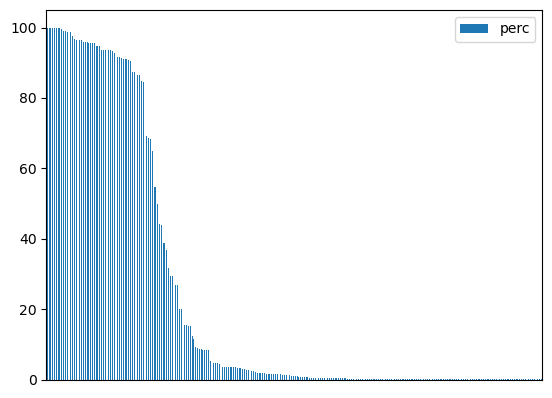

In [3]:
from log_stats import count_cases_per_event

activ_cases_counts = count_cases_per_event('concept:name', 'case:concept:name', log).reset_index()

In [4]:
activ_cases_counts[activ_cases_counts['perc']<1]

,concept:name,cases,perc
137,Study Permit Fee - Refund Request,74,0.956814
138,Study Permit Fee - Refund Complete,67,0.866305
139,Biometrics - RCMP - Received - IMM,63,0.814585
140,Auto Promote Decision - Not Started,61,0.788725
141,Biometrics - RCMP - Entered in Error,60,0.775795
...,...,...,...
269,Non-compliance - Passed,1,0.012930
270,Note Review - Review Complete,1,0.012930
271,Open Work Permit Holder Fee Fee - Outstanding,1,0.012930
272,Other Reqs Assessment - Failed,1,0.012930


In [5]:
activ_cases_counts[activ_cases_counts['perc']<10]

,concept:name,cases,perc
82,Medical - In Progress,708,9.154383
83,Medical Assessment - In Progress,688,8.895785
84,Medical Assessment - Sent,681,8.805275
85,Medical - Sent,681,8.805275
86,Biometric - FCC - NZ - Not Started,651,8.417378
...,...,...,...
269,Non-compliance - Passed,1,0.012930
270,Note Review - Review Complete,1,0.012930
271,Open Work Permit Holder Fee Fee - Outstanding,1,0.012930
272,Other Reqs Assessment - Failed,1,0.012930


In [6]:
# let's filter on activities that occur in 1% or less of cases
to_drop = activ_cases_counts.loc[activ_cases_counts['perc']<1, 'concept:name']
log_filter = log[~ log['concept:name'].isin(to_drop)]

In [7]:
log_filter.to_csv("data/combined_event_log-filt_evt1p.csv")

## Timestamp differences

In [8]:
# log = pd.read_csv("data/combined_event_log_anonymous.csv")

log = pd.read_csv("data/combined_event_log-filt_evt1p.csv")
log = log.drop('Unnamed: 0', axis=1)

log = log.rename({ 'app_num': 'case:concept:name', 'activity_full_value': 'concept:name', 'act_upd_date': 'time:timestamp' }, axis=1)
log['time:timestamp'] = pd.to_datetime(log['time:timestamp'])

/var/folders/b6/7128wh613rqcbppftg_0hb2h0000gn/T/ipykernel_29781/3807961534.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  log = pd.read_csv("data/combined_event_log-filt_evt1p.csv")


In [9]:
from mine_utils import get_time_diff, equal_timestamps_interval

In [10]:
log = get_time_diff(log)

In [11]:
# (check all sequential events with exact same timestamp)
print("num simult (0 sec):", len(log[log['time_diff']==0]), " <> total num:", log.shape[0])

num simult (0 sec): 194914  <> total num: 541096


In [12]:
# (check all sequential events with less than 1min difference in timestamps)
print("num simult (1 min):", len(log[log['time_diff'] < 60]), " <> total num:", log.shape[0])

num simult (1 min): 461641  <> total num: 541096


In [13]:
# (takes ca. 2-4 sec)

log = equal_timestamps_interval(log, 60) # 60 sec

In [14]:
# log.to_csv("data/combined_event_log-time1m.csv")
log.to_csv("data/combined_event_log-filt_evt1p-time1m.csv")

# checkout variant analysis for seeing whether it improved matters

# Subprocesses

## Subprocesses based on status

In [15]:
# log = pd.read_csv("data/combined_event_log_anonymous.csv")
# log = log.rename({ 'app_num': 'case:concept:name', 'act_upd_date': 'time:timestamp' }, axis=1)

log = pd.read_csv("data/combined_event_log-filt_evt1p-time1m.csv")
log = log.drop('Unnamed: 0', axis=1)
log

/var/folders/b6/7128wh613rqcbppftg_0hb2h0000gn/T/ipykernel_29781/2661719508.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  log = pd.read_csv("data/combined_event_log-filt_evt1p-time1m.csv")


,index,case:concept:name,act_upd_by,activity_id,group,activity,activity_status,cor,citz,concept:name,time:timestamp
0,0,0,0,1-SQ1RI5F,NaN,Application Status,Prospective,Vietnam,Vietnam,Application Status - Prospective,2024-06-03 09:20:37.327
1,5,0,2,1-SQ1RI5F,NaN,Biometric Assessment,Required,Vietnam,Vietnam,Biometric Assessment - Required,2024-06-03 09:20:37.327
2,10,0,3,1-SQ1RI7W,NaN,Biometrics - RCMP,Not Started,Vietnam,Vietnam,Biometrics - RCMP - Not Started,2024-06-03 09:20:37.327
3,11,0,4,1-SQ1190E,NaN,Biometrics Fee,Outstanding,Vietnam,Vietnam,Biometrics Fee - Outstanding,2024-06-03 09:20:37.327
4,15,0,4,1-SQ1190E,NaN,Biometrics Fee,Outstanding,Vietnam,Vietnam,Biometrics Fee - Outstanding,2024-06-03 09:20:37.327
...,...,...,...,...,...,...,...,...,...,...,...
541091,541090,7733,9,1-STCSFDC,NaN,Verification,Completed,Belgium,Cameroon,Verification - Completed,2024-06-17 07:46:39.197
541092,541092,7733,281,1-STC2A6X,NaN,Eligibility Assessment,Review Required,Belgium,Cameroon,Eligibility Assessment - Review Required,2024-06-26 08:11:25.043
541093,541095,7733,281,1-STC2A6X,NaN,Application Status,Closed,Belgium,Cameroon,Application Status - Closed,2024-06-28 10:45:09.050
541094,541093,7733,281,1-STC2A6X,NaN,Eligibility Assessment,Failed,Belgium,Cameroon,Eligibility Assessment - Failed,2024-06-28 10:45:09.050


In [16]:
# get all unique activities
log['activity'].drop_duplicates().sort_values().to_excel("data/all_activities.xlsx")

In [17]:
# get activity subprocesses
activ_lifecycles = log[['activity', 'activity_status']].drop_duplicates().sort_values(by=['activity'])
activ_lifecycles.to_excel("data/activity_lifecycles.xlsx")

In [18]:
# count number of sub-activities in each subprocess
counts = log[['activity', 'activity_status']].drop_duplicates().groupby('activity')['activity_status'].count()
counts = counts.sort_values(ascending=False)
counts

activity
Biographic                      12
Biometric - FCC - USA           10
Verification                     6
Eligibility Assessment           6
Candidate ID                     6
Medical Assessment               5
Criminality Assessment           5
Criminality                      5
Integrated Search                5
Candidate ID Decision            5
Medical                          5
Biometrics - RCMP                5
Biometric - FCC Detail - USA     5
Auto Promote                     5
Identity Verification            4
Biometric Assessment             4
Candidate Search                 4
Biometric - FCC - NZ             4
Auto Promote Decision            4
Associate Medicals               4
Final Assessment                 4
Other Reqs Assessment            4
Application Status               3
Post Identity Checks             3
Study Permit Fee                 2
Work Permit Fee                  2
Identity Review                  2
Biometrics Fee                   2
Biometrics 

In [19]:
# only separate subprocesses with >= 3 sub-activities
parent_activ = counts[counts >= 3].reset_index()
parent_activ

,activity,activity_status
0,Biographic,12
1,Biometric - FCC - USA,10
2,Verification,6
3,Eligibility Assessment,6
4,Candidate ID,6
5,Medical Assessment,5
6,Criminality Assessment,5
7,Criminality,5
8,Integrated Search,5
9,Candidate ID Decision,5


In [20]:
subproc_evts = log[log['activity'].isin(parent_activ['activity'])]
subproc_evts

,index,case:concept:name,act_upd_by,activity_id,group,activity,activity_status,cor,citz,concept:name,time:timestamp
0,0,0,0,1-SQ1RI5F,NaN,Application Status,Prospective,Vietnam,Vietnam,Application Status - Prospective,2024-06-03 09:20:37.327
1,5,0,2,1-SQ1RI5F,NaN,Biometric Assessment,Required,Vietnam,Vietnam,Biometric Assessment - Required,2024-06-03 09:20:37.327
2,10,0,3,1-SQ1RI7W,NaN,Biometrics - RCMP,Not Started,Vietnam,Vietnam,Biometrics - RCMP - Not Started,2024-06-03 09:20:37.327
7,30,0,5,1-SQ1S9OF,NaN,Candidate ID,In Progress,Vietnam,Vietnam,Candidate ID - In Progress,2024-06-03 09:20:37.327
8,25,0,5,1-SQ1S9OF,NaN,Candidate ID,Not Started,Vietnam,Vietnam,Candidate ID - Not Started,2024-06-03 09:20:37.327
...,...,...,...,...,...,...,...,...,...,...,...
541091,541090,7733,9,1-STCSFDC,NaN,Verification,Completed,Belgium,Cameroon,Verification - Completed,2024-06-17 07:46:39.197
541092,541092,7733,281,1-STC2A6X,NaN,Eligibility Assessment,Review Required,Belgium,Cameroon,Eligibility Assessment - Review Required,2024-06-26 08:11:25.043
541093,541095,7733,281,1-STC2A6X,NaN,Application Status,Closed,Belgium,Cameroon,Application Status - Closed,2024-06-28 10:45:09.050
541094,541093,7733,281,1-STC2A6X,NaN,Eligibility Assessment,Failed,Belgium,Cameroon,Eligibility Assessment - Failed,2024-06-28 10:45:09.050


In [21]:
non_subproc_evts = log[~ log['activity'].isin(parent_activ['activity'])]
non_subproc_evts

,index,case:concept:name,act_upd_by,activity_id,group,activity,activity_status,cor,citz,concept:name,time:timestamp
3,11,0,4,1-SQ1190E,NaN,Biometrics Fee,Outstanding,Vietnam,Vietnam,Biometrics Fee - Outstanding,2024-06-03 09:20:37.327
4,15,0,4,1-SQ1190E,NaN,Biometrics Fee,Outstanding,Vietnam,Vietnam,Biometrics Fee - Outstanding,2024-06-03 09:20:37.327
5,12,0,4,1-SQ1190E,NaN,Biometrics Fee,Paid,Vietnam,Vietnam,Biometrics Fee - Paid,2024-06-03 09:20:37.327
6,16,0,4,1-SQ1190E,NaN,Biometrics Fee,Paid,Vietnam,Vietnam,Biometrics Fee - Paid,2024-06-03 09:20:37.327
27,3,0,1,0,NaN,Misrepresentation,NIL,Vietnam,Vietnam,Misrepresentation - NIL,2024-06-03 09:20:37.327
...,...,...,...,...,...,...,...,...,...,...,...
541070,541034,7733,1,0,NaN,Received,Date,Belgium,Cameroon,Received - Date,2024-06-06 10:36:57.677
541071,541043,7733,1092,1-STC2A8U,NaN,Study Permit Fee,Outstanding,Belgium,Cameroon,Study Permit Fee - Outstanding,2024-06-06 10:36:57.677
541072,541047,7733,1092,1-STC2A8U,NaN,Study Permit Fee,Outstanding,Belgium,Cameroon,Study Permit Fee - Outstanding,2024-06-06 10:36:57.677
541073,541044,7733,1092,1-STC2A8U,NaN,Study Permit Fee,Paid,Belgium,Cameroon,Study Permit Fee - Paid,2024-06-06 10:36:57.677


### Create separate logs per subprocess

In [22]:
from separ_subproc import separ_subproc

separ_subproc(subproc_evts, non_subproc_evts, 'activity', 'activity_status', 'concept:name', "lifecycles/level2/", "data/combined_event_log-abstracted.csv")

Application Status (# events: 23263)
Associate Medicals (# events: 1097)
Auto Promote (# events: 29528)
Auto Promote Decision (# events: 22250)
Biographic (# events: 30777)
Biometric - FCC - NZ (# events: 2586)
Biometric - FCC - USA (# events: 30328)
Biometric - FCC Detail - USA (# events: 4734)
Biometric Assessment (# events: 14929)
Biometrics - RCMP (# events: 25579)
Candidate ID (# events: 29864)
Candidate ID Decision (# events: 23962)
Candidate Search (# events: 23534)
Criminality (# events: 21929)
Criminality Assessment (# events: 21927)
Eligibility Assessment (# events: 19051)
Final Assessment (# events: 15772)
Identity Verification (# events: 1120)
Integrated Search (# events: 31244)
Medical (# events: 6652)
Medical Assessment (# events: 6636)
Other Reqs Assessment (# events: 20615)
Post Identity Checks (# events: 819)
Verification (# events: 27317)


,case:concept:name,activity,index,act_upd_by,activity_id,group,activity_status,cor,citz,concept:name,time:timestamp
0,0,Application Status,0,0,1-SQ1RI5F,None,Prospective,Vietnam,Vietnam,Application Status [begin],2024-06-03 09:20:37.327
5,0,Biometric Assessment,5,2,1-SQ1RI5F,None,Required,Vietnam,Vietnam,Biometric Assessment [begin],2024-06-03 09:20:37.327
6,0,Biometrics - RCMP,10,3,1-SQ1RI7W,None,Not Started,Vietnam,Vietnam,Biometrics - RCMP [begin],2024-06-03 09:20:37.327
270950,0,Biometrics Fee,11,4,1-SQ1190E,NaN,Outstanding,Vietnam,Vietnam,Biometrics Fee - Outstanding,2024-06-03 09:20:37.327
270951,0,Biometrics Fee,15,4,1-SQ1190E,NaN,Outstanding,Vietnam,Vietnam,Biometrics Fee - Outstanding,2024-06-03 09:20:37.327
...,...,...,...,...,...,...,...,...,...,...,...
270948,7733,Other Reqs Assessment,541091,281,1-STC2A6X,None,NIL,Belgium,Cameroon,Other Reqs Assessment [end],2024-06-17 07:46:39.197
270949,7733,Verification,541090,9,1-STCSFDC,None,Completed,Belgium,Cameroon,Verification [end],2024-06-17 07:46:39.197
270933,7733,Application Status,541095,281,1-STC2A6X,None,Closed,Belgium,Cameroon,Application Status [end],2024-06-28 10:45:09.050
270945,7733,Eligibility Assessment,541093,281,1-STC2A6X,None,Failed,Belgium,Cameroon,Eligibility Assessment [end],2024-06-28 10:45:09.050


## Subprocesses based on nesting

In [23]:
nestings = pd.read_excel("data/nested_activities-fixed.xlsx")
nestings

,Activity,Parent Item
0,Associate Medicals,Medical Activity
1,Biographic,Info Sharing Assessment
2,Biographic - Correction,Info Sharing Assessment
3,Biometric - FCC - AUS,Info Sharing Assessment
4,Biometric - FCC - NZ,Info Sharing Assessment
5,Biometric - FCC - USA,Info Sharing Assessment
6,Biometric - FCC Detail - AUS,Info Sharing Assessment
7,Biometric - FCC Detail - USA,Info Sharing Assessment
8,Biometric - FCC Reciprocal - AUS,Info Sharing Assessment
9,Biometric Assessment,Info Sharing Assessment


In [24]:
# make sure there's no non-existent activities in the nesting file
or_log = pd.read_csv("data/combined_event_log_anonymous.csv")
nestings[~ nestings['Activity'].isin(or_log['activity'])].sort_values(by='Activity')

/var/folders/b6/7128wh613rqcbppftg_0hb2h0000gn/T/ipykernel_29781/4061471006.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  or_log = pd.read_csv("data/combined_event_log_anonymous.csv")


,Activity,Parent Item


In [25]:
abstr_log = pd.read_csv("data/combined_event_log-abstracted.csv")
abstr_log

/var/folders/b6/7128wh613rqcbppftg_0hb2h0000gn/T/ipykernel_29781/3727316693.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  abstr_log = pd.read_csv("data/combined_event_log-abstracted.csv")


,case:concept:name,activity,index,act_upd_by,activity_id,group,activity_status,cor,citz,concept:name,time:timestamp
0,0,Application Status,0,0,1-SQ1RI5F,NaN,Prospective,Vietnam,Vietnam,Application Status [begin],2024-06-03 09:20:37.327
1,0,Biometric Assessment,5,2,1-SQ1RI5F,NaN,Required,Vietnam,Vietnam,Biometric Assessment [begin],2024-06-03 09:20:37.327
2,0,Biometrics - RCMP,10,3,1-SQ1RI7W,NaN,Not Started,Vietnam,Vietnam,Biometrics - RCMP [begin],2024-06-03 09:20:37.327
3,0,Biometrics Fee,11,4,1-SQ1190E,NaN,Outstanding,Vietnam,Vietnam,Biometrics Fee - Outstanding,2024-06-03 09:20:37.327
4,0,Biometrics Fee,15,4,1-SQ1190E,NaN,Outstanding,Vietnam,Vietnam,Biometrics Fee - Outstanding,2024-06-03 09:20:37.327
...,...,...,...,...,...,...,...,...,...,...,...
376528,7733,Other Reqs Assessment,541091,281,1-STC2A6X,NaN,NIL,Belgium,Cameroon,Other Reqs Assessment [end],2024-06-17 07:46:39.197
376529,7733,Verification,541090,9,1-STCSFDC,NaN,Completed,Belgium,Cameroon,Verification [end],2024-06-17 07:46:39.197
376530,7733,Application Status,541095,281,1-STC2A6X,NaN,Closed,Belgium,Cameroon,Application Status [end],2024-06-28 10:45:09.050
376531,7733,Eligibility Assessment,541093,281,1-STC2A6X,NaN,Failed,Belgium,Cameroon,Eligibility Assessment [end],2024-06-28 10:45:09.050


In [26]:
# connect parent items to events
# left merge; also keep events that are not being nested
abstr_log_parent = abstr_log.merge(nestings, left_on='activity', right_on='Activity', how='left')
abstr_log_parent

,case:concept:name,activity,index,act_upd_by,activity_id,group,activity_status,cor,citz,concept:name,time:timestamp,Activity,Parent Item
0,0,Application Status,0,0,1-SQ1RI5F,NaN,Prospective,Vietnam,Vietnam,Application Status [begin],2024-06-03 09:20:37.327,NaN,NaN
1,0,Biometric Assessment,5,2,1-SQ1RI5F,NaN,Required,Vietnam,Vietnam,Biometric Assessment [begin],2024-06-03 09:20:37.327,Biometric Assessment,Info Sharing Assessment
2,0,Biometrics - RCMP,10,3,1-SQ1RI7W,NaN,Not Started,Vietnam,Vietnam,Biometrics - RCMP [begin],2024-06-03 09:20:37.327,Biometrics - RCMP,Criminality Activity
3,0,Biometrics Fee,11,4,1-SQ1190E,NaN,Outstanding,Vietnam,Vietnam,Biometrics Fee - Outstanding,2024-06-03 09:20:37.327,Biometrics Fee,Cost Recovery
4,0,Biometrics Fee,15,4,1-SQ1190E,NaN,Outstanding,Vietnam,Vietnam,Biometrics Fee - Outstanding,2024-06-03 09:20:37.327,Biometrics Fee,Cost Recovery
...,...,...,...,...,...,...,...,...,...,...,...,...,...
376528,7733,Other Reqs Assessment,541091,281,1-STC2A6X,NaN,NIL,Belgium,Cameroon,Other Reqs Assessment [end],2024-06-17 07:46:39.197,NaN,NaN
376529,7733,Verification,541090,9,1-STCSFDC,NaN,Completed,Belgium,Cameroon,Verification [end],2024-06-17 07:46:39.197,Verification,Other Req Assessment
376530,7733,Application Status,541095,281,1-STC2A6X,NaN,Closed,Belgium,Cameroon,Application Status [end],2024-06-28 10:45:09.050,NaN,NaN
376531,7733,Eligibility Assessment,541093,281,1-STC2A6X,NaN,Failed,Belgium,Cameroon,Eligibility Assessment [end],2024-06-28 10:45:09.050,NaN,NaN


In [27]:
subproc_evts = abstr_log_parent[abstr_log_parent['Parent Item'].notna()]
# (non-nested events; those not merged with parent)
non_subproc_evts = abstr_log_parent[abstr_log_parent['Parent Item'].isna()]

### Create separate logs per nested activity

In [28]:
from separ_subproc import separ_subproc

separ_subproc(subproc_evts, non_subproc_evts, 'Parent Item', 'concept:name', 'concept:name', "lifecycles/level1", "data/combined_event_log-abstracted2.csv")

Cost Recovery (# events: 82369)
Criminality Activity (# events: 43613)
Info Sharing Assessment (# events: 50046)
Medical Activity (# events: 12728)
Other Req Assessment (# events: 14438)


,case:concept:name,Parent Item,activity,index,act_upd_by,activity_id,group,activity_status,cor,citz,concept:name,time:timestamp,Activity
65278,0,NaN,Application Status,0,0,1-SQ1RI5F,NaN,Prospective,Vietnam,Vietnam,Application Status [begin],2024-06-03 09:20:37.327,NaN
65279,0,NaN,Candidate ID Decision,27,6,1-SQ1JBR7,NaN,In Progress,Vietnam,Vietnam,Candidate ID Decision [begin],2024-06-03 09:20:37.327,NaN
65280,0,NaN,Candidate ID,30,5,1-SQ1S9OF,NaN,In Progress,Vietnam,Vietnam,Candidate ID [begin],2024-06-03 09:20:37.327,NaN
65281,0,NaN,Candidate Search,29,5,1-SQ11912,NaN,Complete,Vietnam,Vietnam,Candidate Search [begin],2024-06-03 09:20:37.327,NaN
65282,0,NaN,Candidate Search,19,5,1-SQ11912,NaN,Submit,Vietnam,Vietnam,Candidate Search [end],2024-06-03 09:20:37.327,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65277,7733,Other Req Assessment,Verification,541090,9,1-STCSFDC,None,Completed,Belgium,Cameroon,Other Req Assessment [end],2024-06-17 07:46:39.197,Verification
238613,7733,NaN,Other Reqs Assessment,541091,281,1-STC2A6X,NaN,NIL,Belgium,Cameroon,Other Reqs Assessment [end],2024-06-17 07:46:39.197,NaN
238614,7733,NaN,Application Status,541095,281,1-STC2A6X,NaN,Closed,Belgium,Cameroon,Application Status [end],2024-06-28 10:45:09.050,NaN
238615,7733,NaN,Eligibility Assessment,541093,281,1-STC2A6X,NaN,Failed,Belgium,Cameroon,Eligibility Assessment [end],2024-06-28 10:45:09.050,NaN


## Sanity check

In [29]:
import os

dir = "lifecycles/level2/logs"
sublogs_lvl2 = [ (f, pd.read_csv(os.path.join(dir, f))) for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f)) ]

### Check original events

In [30]:
# same input as subprocesses part
# (NOTE - original log will have to be extended with index for sanity code to work)
log = pd.read_csv("data/combined_event_log-filt_evt1p-time1m.csv")

/var/folders/b6/7128wh613rqcbppftg_0hb2h0000gn/T/ipykernel_29781/1462164325.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  log = pd.read_csv("data/combined_event_log-filt_evt1p-time1m.csv")


In [31]:
from collections import defaultdict

found_indexes = set()

# > subprocesses based on status

# - find original events in the sublogs

for f, sublog in sublogs_lvl2:    
    f_name = f[0:f.index(".")]
    
    # join original log with the sublog
    log_merged = log.merge(sublog, left_on='index', right_on='index')
    # print(log_merged)
    
    # (apply same string operation as on the file name)
    activ_file = (log_merged['activity_x'].str.replace("/", "_") == f_name)
    # for all matches, activity names should correspond to file name
    assert (activ_file).all(), f_name + " <> " + log_merged[~ activ_file]['activity_x']
    # for all matches, activity statuses should correspond to sublog activity name
    assert (log_merged['activity_status'] == log_merged['concept:name_y']).all(), "file: {f_name}"
    
    found_indexes.update(log_merged['index'])

In [32]:
# - find original events in the abstracted log

# only interested in activities without parent (non-nested)
log_filter = log[~ log['activity'].isin(parent_activ['activity'])]
# join original log with the abstracted log
log_merged = log_filter.merge(abstr_log, left_on='index', right_on='index')
# print(log_merged)

activ_name = (log_merged['concept:name_x'] == log_merged['concept:name_y'])
# activity names should correspond
assert (activ_name).all(), log_merged[~ activ_name][['concept:name_x', 'concept:name_y']]

found_indexes.update(log_merged['index'])

In [33]:
# all events found?
assert len(found_indexes) == log.shape[0], f"{len(found_indexes)} <> {log.shape[0]}"

### Check subprocesses

In [34]:
# > subprocesses based on nesting

# per case, check if activity's start/end markers correspond to first & last sorted events of the activity

def check_subproc(abstr_log, marker_label, is_start):
    # group all start/end markers by activity
    groups = abstr_log[abstr_log['concept:name'].str.endswith(marker_label)].groupby('activity')

    # for each activity & their markers for all cases
    for activ, g in groups:
        # sort on case
        g = g.sort_values(by='case:concept:name').reset_index()
        
        # find sublog corresponding to activity
        for i in [ 1, 2 ]:
            path = f"lifecycles/level2/logs/{activ.replace('/', '_')}.csv"
            if not os.path.exists(path):
                continue
            sublog = pd.read_csv(path)
        
        # print(activ, path)
        
        # first, in the activity's sublog, find the firsts/lasts for each case
        gb = sublog.groupby('case:concept:name')
        delims = (gb.first() if is_start else gb.last()).reset_index()
        # also sort on case
        delims = delims.sort_values(by='case:concept:name').reset_index()
        
        # firsts/lasts should be the same as the start/end markers
        assert(g['index'] == delims['index']).all(), activ
        
check_subproc(abstr_log, " [begin]", True)
check_subproc(abstr_log, " [end]", False)

path = "lifecycles/level1/logs/"

from pathlib import Path
paths = Path(path).rglob("*.csv")
for path in paths:
    abstr_sublog = pd.read_csv(path)
    check_subproc(abstr_sublog, " [begin]", True)
    check_subproc(abstr_sublog, " [end]", False)
    

## Timestamp differences (bis)

In [35]:
log = get_log("data/combined_event_log-abstracted2.csv")
log = log[['case:concept:name', 'concept:name', 'time:timestamp']]
log

,case:concept:name,concept:name,time:timestamp
0,0,Application Status [begin],2024-06-03 09:20:37.327
1,0,Candidate ID Decision [begin],2024-06-03 09:20:37.327
2,0,Candidate ID [begin],2024-06-03 09:20:37.327
3,0,Candidate Search [begin],2024-06-03 09:20:37.327
4,0,Candidate Search [end],2024-06-03 09:20:37.327
...,...,...,...
238612,7733,Other Req Assessment [end],2024-06-17 07:46:39.197
238613,7733,Other Reqs Assessment [end],2024-06-17 07:46:39.197
238614,7733,Application Status [end],2024-06-28 10:45:09.050
238615,7733,Eligibility Assessment [end],2024-06-28 10:45:09.050


In [36]:
from mine_utils import get_time_diff

logd = get_time_diff(log)

In [37]:
# (check all sequential events with less than 1min difference in timestamps)
print("num simult (1 min):", len(logd[ (logd['time_diff'] > 0) & (logd['time_diff'] < 60)]), " <> total num:", logd.shape[0])

# none to be found

num simult (1 min): 0  <> total num: 238617


## Variant analysis (bis)

In [40]:
from variant_stats import get_variants_stats, get_variant_ratio, get_variant_coverage, get_covering_variants, filter_traces_on_variants

# traces = 7734, # vars = 3462, ratio = 44.76


,sequence,cov_amt,cov_perc,cov_perc_cumul,var_perc_cumul
0,"(Application Status [begin], Auto Promote Decision [begin], Auto Promote Decision [end], Auto Promote [begin], Auto Promote [end], Candidate ID Decision [begin], Candidate ID Decision [end], Candi...",140,1.810189,1.810189,0.028885
1,"(Application Status [begin], Candidate ID Decision [begin], Candidate ID [begin], Candidate ID [end], Candidate Search [begin], Candidate Search [end], Cost Recovery [begin], Cost Recovery [end], ...",79,1.021464,2.831652,0.057770
2,"(Application Status [begin], Auto Promote Decision [begin], Auto Promote Decision [end], Auto Promote [begin], Auto Promote [end], Candidate ID Decision [begin], Candidate ID Decision [end], Candi...",77,0.995604,3.827256,0.086655
3,"(Application Status [begin], Auto Promote Decision [begin], Auto Promote Decision [end], Auto Promote [begin], Auto Promote [end], Candidate ID Decision [begin], Candidate ID Decision [end], Candi...",75,0.969744,4.797000,0.115540
4,"(Application Status [begin], Auto Promote Decision [begin], Auto Promote Decision [end], Auto Promote [begin], Auto Promote [end], Candidate ID Decision [begin], Candidate ID Decision [end], Candi...",73,0.943884,5.740884,0.144425
...,...,...,...,...,...
3457,"(Application Status [begin], Criminality Activity [begin], Eligibility Assessment [begin], Final Assessment [begin], Info Sharing Assessment [begin], Misrepresentation - NIL, Received - Date, Cand...",1,0.012930,99.948280,99.884460
3458,"(Application Status [begin], Criminality Activity [begin], Eligibility Assessment [begin], Final Assessment [begin], Info Sharing Assessment [begin], Misrepresentation - NIL, Received - Date, Cand...",1,0.012930,99.961210,99.913345
3459,"(Application Status [begin], Criminality Activity [begin], Eligibility Assessment [begin], Final Assessment [begin], Info Sharing Assessment [begin], Misrepresentation - NIL, Received - Date, Cost...",1,0.012930,99.974140,99.942230
3460,"(Application Status [begin], Candidate ID Decision [begin], Candidate ID [begin], Candidate ID [end], Candidate Search [begin], Candidate Search [end], Criminality Activity [begin], Eligibility As...",1,0.012930,99.987070,99.971115


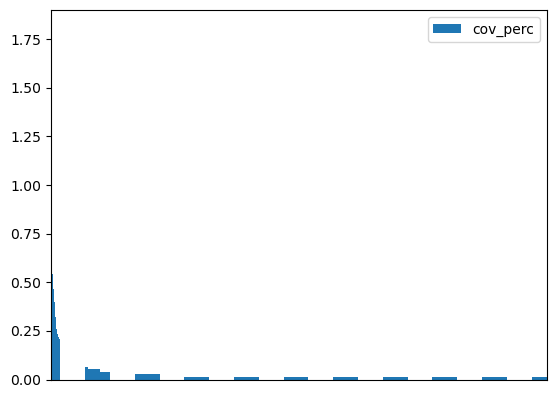

In [41]:
var_stats = get_variants_stats(log)
print(get_variant_ratio(log, var_stats))
var_stats

In [42]:
singleton_vars = var_stats[var_stats['cov_amt']==1]

# ooph, a lot of traces here ...
singleton_vars['cov_amt'].sum() / var_stats['cov_amt'].sum()

0.3342384277217481

## Infrequent events (bis)

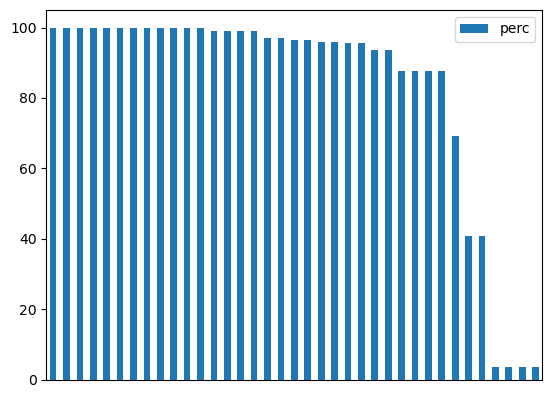

In [43]:
log = pd.read_csv("data/combined_event_log-abstracted2.csv")

from log_stats import count_cases_per_event
activ_cases_counts = count_cases_per_event('concept:name', 'case:concept:name', log).reset_index()

In [44]:
activ_cases_counts[activ_cases_counts['perc']<1]

,concept:name,cases,perc


# Mine process models

In [53]:
from mine_utils import ProcAnn, mine_heur, mine_induct, mine_alpha
import pm4py.objects.log.exporter.xes.exporter as xes_export
from pathlib import Path

In [54]:
# ad-hoc mining & converting

# log = get_log("data/combined_event_log-abstracted2.csv")

# cost_recov = log[(log['concept:name']=='Cost Recovery [begin]') | (log['concept:name']=='Cost Recovery [end]')]

# log = log[['case:concept:name', 'time:timestamp', 'concept:name']]
# cost_recov.to_csv("data/cost_recov.csv")
# xes_export.apply(cost_recov, "data/cost_recov.xes")

# mine_heur(log, ProcAnn.FREQ, "graphs/combined_event_log-abstracted2-time1m")
# mine_induct(log, convert_to='petri_net', output_path="graphs/combined_event_log-abstracted2-time1m-pn")

# log = log[['case:concept:name', 'time:timestamp', 'concept:name']]
# xes_export.apply(log, "data/combined_event_log-abstracted2.xes")

In [55]:
import shutil, os

def init_subdir(subdir, subsubdirs=[]):
    if os.path.exists(subdir):
        shutil.rmtree(subdir)
    os.mkdir(subdir)
    for subsubdir in subsubdirs:
        os.mkdir(os.path.join(subdir, subsubdir))

In [56]:
induct_formats = ['bpmn', 'petri_net']
formats_with_ann = ['dfg']

In [57]:
def save_entries_json(names, default_format, default_ann, path):
    def entry_pref():
        if default_format in formats_with_ann:
            return f"{{ \"format\": \"{default_format}\", \"ann\": \"{default_ann.value}\" }}"
        else:
            return f"{{ \"format\": \"{default_format}\" }}"
    
    all = "[" + ", ".join(map(lambda n: f"\"{n}\"", names)) + "]"
    prefs = "{" + ", ".join(map(lambda n: f"\"{n}\": {entry_pref()}", names)) + "}"
    obj = f"{{ \"all\": {all}, \"prefs\": {prefs} }}"
    open(os.path.join(path, "graphs.json"), "w").write(obj)

In [58]:
# mine process models for sublogs
# (ca. 1 min)

for lvl in [ 1, 2 ]:
    # subprocess level (levels 1-2)
    subdir = f"lifecycles/level{lvl}"

    # default model & annotation to be shown
    default_format = "dfg"
    default_ann = ProcAnn.FREQ

    init_subdir(os.path.join(subdir, "xes"))
    init_subdir(os.path.join(subdir, "dfg"), [ ProcAnn.FREQ.value, ProcAnn.PERF.value ])
    for format in induct_formats:
        init_subdir(os.path.join(subdir, format))

    names = [ ]
    for path in Path(os.path.join(subdir, "logs")).rglob("*.csv"):
        file = os.path.basename(path)
        name = file[0: file.index(".csv")]
        print(name)
        names.append(name)
        
        log = pd.read_csv(path)
        log = log[['case:concept:name', 'time:timestamp', 'concept:name']]
        
        log['case:concept:name'] = log['case:concept:name'].astype('int64')
        log['time:timestamp'] = pd.to_datetime(log['time:timestamp'])
        
        xes_export.apply(log, os.path.join(subdir, "xes", name + ".xes"))
        
        for ann in ProcAnn:
            mine_heur(log, ann, output_path=os.path.join(subdir, "dfg", ann.value, name), save_gviz=True)
        
        for format in induct_formats:
            mine_induct(log, convert_to=format, output_path=os.path.join(subdir, format, name), save_gviz=True)

    save_entries_json(names, default_format, default_ann, subdir)

Medical Activity


exporting log, completed traces ::   0%|          | 0/3163 [00:00<?, ?it/s]

Info Sharing Assessment


exporting log, completed traces ::   0%|          | 0/7734 [00:00<?, ?it/s]

Cost Recovery


exporting log, completed traces ::   0%|          | 0/7734 [00:00<?, ?it/s]

Other Req Assessment


exporting log, completed traces ::   0%|          | 0/6772 [00:00<?, ?it/s]

Criminality Activity


exporting log, completed traces ::   0%|          | 0/7236 [00:00<?, ?it/s]

Candidate ID Decision


exporting log, completed traces ::   0%|          | 0/7512 [00:00<?, ?it/s]

Associate Medicals


exporting log, completed traces ::   0%|          | 0/280 [00:00<?, ?it/s]

Biometric - FCC - NZ


exporting log, completed traces ::   0%|          | 0/658 [00:00<?, ?it/s]

Candidate Search


exporting log, completed traces ::   0%|          | 0/7651 [00:00<?, ?it/s]

Identity Verification


exporting log, completed traces ::   0%|          | 0/280 [00:00<?, ?it/s]

Candidate ID


exporting log, completed traces ::   0%|          | 0/7457 [00:00<?, ?it/s]

Auto Promote Decision


exporting log, completed traces ::   0%|          | 0/7415 [00:00<?, ?it/s]

Eligibility Assessment


exporting log, completed traces ::   0%|          | 0/7734 [00:00<?, ?it/s]

Biometric Assessment


exporting log, completed traces ::   0%|          | 0/7734 [00:00<?, ?it/s]

Criminality


exporting log, completed traces ::   0%|          | 0/7236 [00:00<?, ?it/s]

Auto Promote


exporting log, completed traces ::   0%|          | 0/7388 [00:00<?, ?it/s]

Criminality Assessment


exporting log, completed traces ::   0%|          | 0/7236 [00:00<?, ?it/s]

Medical Assessment


exporting log, completed traces ::   0%|          | 0/3042 [00:00<?, ?it/s]

Biographic


exporting log, completed traces ::   0%|          | 0/7711 [00:00<?, ?it/s]

Verification


exporting log, completed traces ::   0%|          | 0/6768 [00:00<?, ?it/s]

Integrated Search


exporting log, completed traces ::   0%|          | 0/7650 [00:00<?, ?it/s]

Other Reqs Assessment


exporting log, completed traces ::   0%|          | 0/6775 [00:00<?, ?it/s]

Biometric - FCC Detail - USA


exporting log, completed traces ::   0%|          | 0/1188 [00:00<?, ?it/s]

Post Identity Checks


exporting log, completed traces ::   0%|          | 0/282 [00:00<?, ?it/s]

Final Assessment


exporting log, completed traces ::   0%|          | 0/7734 [00:00<?, ?it/s]

Biometric - FCC - USA


exporting log, completed traces ::   0%|          | 0/7732 [00:00<?, ?it/s]

Medical


exporting log, completed traces ::   0%|          | 0/3042 [00:00<?, ?it/s]

Biometrics - RCMP


exporting log, completed traces ::   0%|          | 0/7236 [00:00<?, ?it/s]

Application Status


exporting log, completed traces ::   0%|          | 0/7734 [00:00<?, ?it/s]

In [59]:
# mine models for main process
# (ca. 20-30 sec)

log = pd.read_csv("data/combined_event_log-abstracted2.csv")
log = log[['case:concept:name', 'time:timestamp', 'concept:name']]
log['time:timestamp'] = pd.to_datetime(log['time:timestamp'])

subdir = "lifecycles/level0"

default_format = "dcr"
default_ann = ProcAnn.FREQ

init_subdir(os.path.join(subdir, "logs"))
init_subdir(os.path.join(subdir, "dfg"), [ ProcAnn.FREQ.value, ProcAnn.PERF.value ])
init_subdir(os.path.join(subdir, "bpmn"))
init_subdir(os.path.join(subdir, "petri_net"))
init_subdir(os.path.join(subdir, "xes"))

name = "main"
log.to_csv(os.path.join(subdir, "logs", name + ".csv"))

for ann in ProcAnn:
    mine_heur(log, ann, output_path=os.path.join(subdir, "dfg", ann.value, name), save_gviz=True)

for format in induct_formats:
    mine_induct(log, convert_to=format, output_path=os.path.join(subdir, format, name), save_gviz=True)

xes_export.apply(log, os.path.join(subdir, "xes", name + ".xes"))

save_entries_json([name], default_format, default_ann, subdir)

exporting log, completed traces ::   0%|          | 0/7734 [00:00<?, ?it/s]

In [60]:
# mine DCR: see
# /Users/wvw/git/pm/declarative/dcr4py/pm4py-dcr/ircc_dcr.ipynb